# Skew Matrix Learning (SKEW)

- Original code from Y. Chen

- Modified by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target_ms_sep_sc.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input_ms_sep_sc.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return gradient[0]

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
class MLPS(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLPS, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

In [6]:
import time
input_size = 4
hidden_size = 200
output_size = 1

input_size_s = 4
hidden_size_s = 200
output_size_s = 6

num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  h_nn = MLP(input_size, hidden_size, output_size).to(device)
  s_nn = MLPS(input_size_s, hidden_size_s, output_size_s).to(device)
  num_epochs = 2000
  criterion = nn.MSELoss()
  parmas = list(h_nn.parameters()) + list(s_nn.parameters())
  optimizer = optim.Adam(params=parmas,lr=0.0001)

  history_loss = []
  history_eval = []
  history_acc = []
  startt = time.time()
  for epoch in range(num_epochs):
    estartt = time.time()
    h_nn.train()
    s_nn.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      x = data.to(device)
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4).to(device)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]
      
      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = output.squeeze(2)

      target = target.to(device)

      loss = criterion(output,target)
      loss.backward()
      optimizer.step()
     

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt
  
    num_correct = 0
    num_data = 0
    h_nn.eval()
    s_nn.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      optimizer.zero_grad()
      x = data.to(device)
      output = h_nn.grad(x)
      skew_init = s_nn.forward(x)
      skew_n = torch.zeros(skew_init.shape[0],4,4).to(device)
      skew_n[:,0,1] = skew_init[:,0]
      skew_n[:,0,2] = skew_init[:,1]
      skew_n[:,0,3] = skew_init[:,2]
      skew_n[:,1,2] = skew_init[:,3]
      skew_n[:,1,3] = skew_init[:,4]
      skew_n[:,2,3] = skew_init[:,5]
      skew_n[:,1,0] = -skew_init[:,0]
      skew_n[:,2,0] = -skew_init[:,1]
      skew_n[:,3,0] = -skew_init[:,2]
      skew_n[:,2,1] = -skew_init[:,3]
      skew_n[:,3,1] = -skew_init[:,4]
      skew_n[:,3,2] = -skew_init[:,5]
      
      output = output.unsqueeze(2)
      output = torch.matmul(skew_n, output)
      output = output.squeeze(2)

      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt

    history_loss.append(total_loss)
    history_eval.append(eval_loss)
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  path = "./model/danieljh_skew_h_ms_v1_sep_sc_lr_{}".format(trial)
  torch.save(h_nn.state_dict(), path)
  path = "./model/danieljh_skew_s_ms_v1_sep_sc_lr_{}".format(trial)
  torch.save(s_nn.state_dict(), path)
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))

2000/2000 training loss:3.081610273056867e-05,evaluation loss:2.9962433472974226e-05
2000/2000 training loss:7.020384796305735e-05,evaluation loss:6.985835607338231e-05
2000/2000 training loss:0.0002924787762822234,evaluation loss:0.0002818744760588743
2000/2000 training loss:2.834823121702357e-05,evaluation loss:2.7937286540691274e-05
2000/2000 training loss:3.7687789199480906e-05,evaluation loss:3.723620338860201e-05
2000/2000 training loss:0.0003025040285137948,evaluation loss:0.00029427960616885686
2000/2000 training loss:7.737401074336958e-05,evaluation loss:7.823855630704202e-05
2000/2000 training loss:3.486271259589557e-05,evaluation loss:3.492295682008262e-05
2000/2000 training loss:3.6684661768049406e-05,evaluation loss:4.0076291770674286e-05
2000/2000 training loss:3.338538583648187e-05,evaluation loss:3.5896117424272234e-05
train_loss:9.44345546849945e-05, std: 0.00010278052804195688
test_loss:9.302822840254521e-05, std: 9.883910320943123e-05
computation_time:1135.6413830280

In [7]:
import pandas as pd
A = pd.read_csv("./data/A_ms_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B_ms_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

(0.91369884, 0.76173912, 0.7811432, 0.44947022)


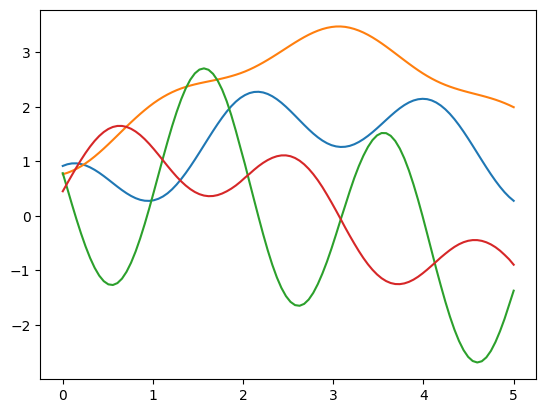

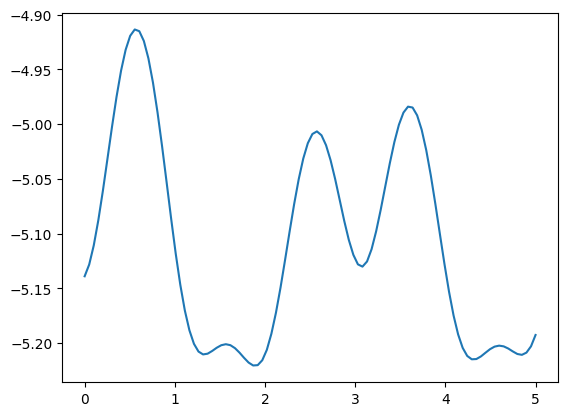

In [8]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

trial = num_trials - 1

s_nn.load_state_dict(torch.load("./model/danieljh_skew_s_ms_v1_sep_sc_lr_{}".format(trial), map_location=device))
s_nn.eval()
h_nn.load_state_dict(torch.load("./model/danieljh_skew_h_ms_v1_sep_sc_lr_{}".format(trial), map_location=device))
h_nn.eval()
teval = torch.linspace(0.0,5.0,100)
# 초기값 (q1, q2, v1, v2 순서)
x0 = (0.91369884, 0.76173912, 0.7811432,  0.44947022)

print(x0)
dt = teval[1]-teval[0]
teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
h_nn.cpu()
s_nn.cpu()

def fvec_np(x, t):
    tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
    x = torch.matmul(tx, torch.inverse(B))
    output = h_nn.grad(x)
    skew_init = s_nn.forward(x)
    skew_n = torch.zeros(skew_init.shape[0],4,4)
    skew_n[:,0,1] = skew_init[:,0]
    skew_n[:,0,2] = skew_init[:,1]
    skew_n[:,0,3] = skew_init[:,2]
    skew_n[:,1,2] = skew_init[:,3]
    skew_n[:,1,3] = skew_init[:,4]
    skew_n[:,2,3] = skew_init[:,5]
    skew_n[:,1,0] = -skew_init[:,0]
    skew_n[:,2,0] = -skew_init[:,1]
    skew_n[:,3,0] = -skew_init[:,2]
    skew_n[:,2,1] = -skew_init[:,3]
    skew_n[:,3,1] = -skew_init[:,4]
    skew_n[:,3,2] = -skew_init[:,5]

    output = output.unsqueeze(2)
    output = torch.matmul(skew_n, output)
    output = torch.matmul(A, output)
    output = output.squeeze(2)
    output = output.squeeze(0)

    return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np, x0, teval)

skew_x = res.copy()

plt.plot(teval,res[:,0])
plt.plot(teval,res[:,1])
plt.plot(teval,res[:,2])
plt.plot(teval,res[:,3])
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = h_nn(x).squeeze(0)
  return ne.detach().cpu().numpy()

net_energy = net_energy(res, teval).reshape((100))
plt.plot(teval,net_energy)
plt.show()
    

In [ ]:
def Hamiltonian_qv(orbits_qv):
    """
    Computes the energy (Hamiltonian) of the system
    based on the given state vector (q1, q2, v1, v2)
    """
    q1 = orbits_qv[:,0]
    q2 = orbits_qv[:,1]
    v1 = orbits_qv[:,2]
    v2 = orbits_qv[:,3]
    
    # Kinetic Energy: K = 0.5 * m * v^2
    kinetic = 0.5 * (m1 * (v1**2) + m2 * (v2**2))
    
    # Potential Energy: V = 0.5 * k * x^2
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)

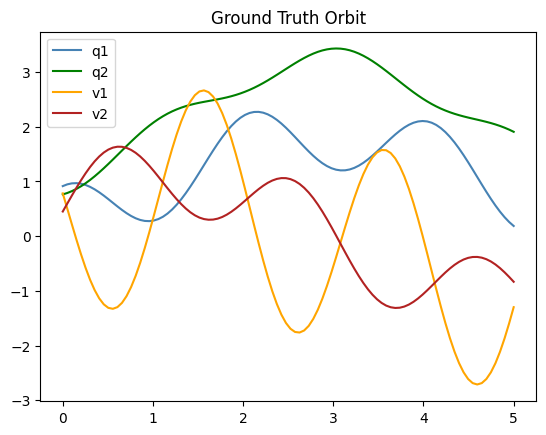

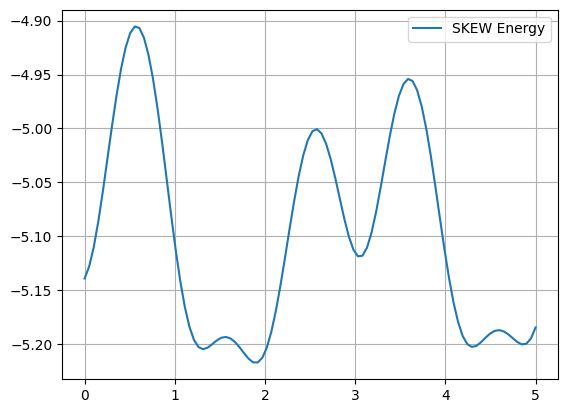

In [ ]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)
x0 = state[0]

sol = solver(func, [0, tend], x0, t_eval=t_eval)

tval = sol['t']
true_x = sol['y'].T # (M, 4) [q1, q2, v1, v2]

ax=plt.subplot()
ax.plot(tval, true_x[:, 0], 'steelblue', label='q1')
ax.plot(tval, true_x[:, 1], 'g', label='q2')
ax.plot(tval, true_x[:, 2], 'orange', label='v1')
ax.plot(tval, true_x[:, 3], 'firebrick', label='v2')
ax.legend()
plt.title("Ground Truth Orbit")
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = h_nn(x).squeeze(0)
  return ne.detach().cpu().numpy()

skew_energy_true_x = net_energy(true_x, teval).reshape((100))
plt.plot(tval,skew_energy_true_x, label='SKEW Energy')
plt.legend()
plt.grid(True)
plt.show()


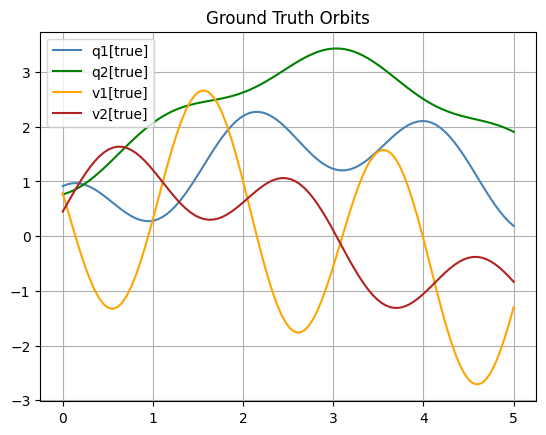

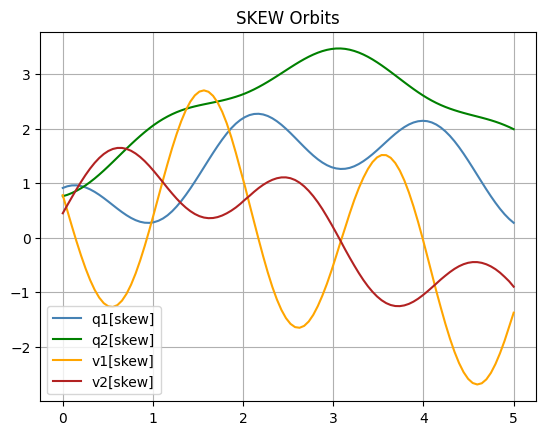

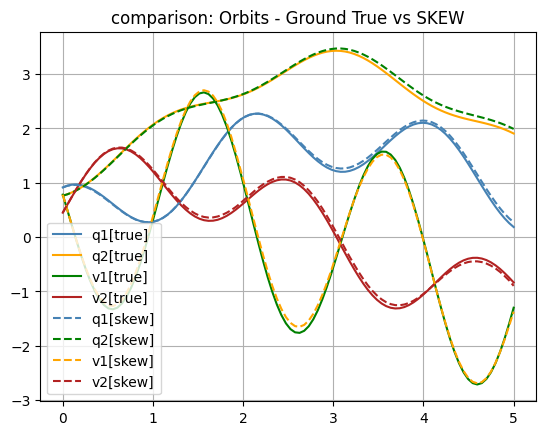

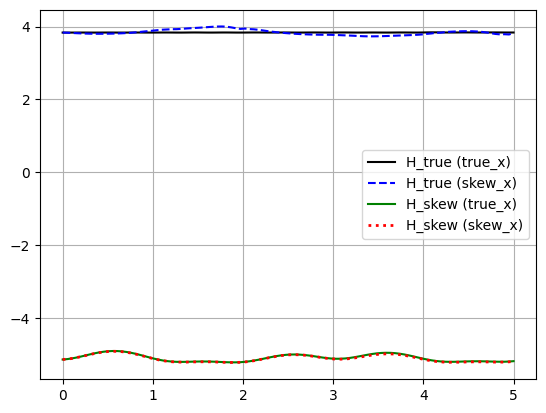

In [13]:
plt.title("Ground Truth Orbits")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'orange', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("SKEW Orbits")
plt.plot(tval, skew_x[:,0], 'steelblue', label='q1[skew]', linestyle='-')
plt.plot(tval, skew_x[:,1], 'g', label='q2[skew]', linestyle='-')
plt.plot(tval, skew_x[:,2], 'orange', label='v1[skew]', linestyle='-')
plt.plot(tval, skew_x[:,3], 'firebrick', label='v2[skew]',linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground True vs SKEW")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'orange', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'g', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.plot(tval, skew_x[:,0], 'steelblue', label='q1[skew]', linestyle='--')
plt.plot(tval, skew_x[:,1], 'g', label='q2[skew]', linestyle='--')
plt.plot(tval, skew_x[:,2], 'orange', label='v1[skew]', linestyle='--')
plt.plot(tval, skew_x[:,3], 'firebrick', label='v2[skew]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

skew_energy_skew_x = net_energy(skew_x, teval).reshape((100))
skew_energy_true_x = net_energy(true_x, teval).reshape((100))
true_energy_skew_x = Hamiltonian_qv(skew_x)
true_energy_true_x = Hamiltonian_qv(true_x)

plt.plot(teval,true_energy_true_x, label='H_true (true_x)', color='k', linestyle='-')
plt.plot(teval,true_energy_skew_x, label='H_true (skew_x)', color='b',linestyle='--')
plt.plot(teval,skew_energy_true_x, label='H_skew (true_x)', color='g', linestyle='-', lw=1.5)
plt.plot(teval,skew_energy_skew_x, label='H_skew (skew_x)', color='r', linestyle=':', lw=2)
plt.legend()
plt.grid(True)
plt.show()